This jupyter notebook is part of the supplementary material for the book "Materials Data Science" (Stefan Sandfeld, Springer, 2024, DOI 10.1007/978-3-031-46565-9). For further details please refer to the accompanying webpage https://mds-book.org.

## 4.2 Dataset MDS-1: Tensile Test with Parameter Uncertainties

### a) How to create the dataset

As a first step, we show how to create the stress-strain dataset. This is also the way how the data in the git repository "MDSdata" was created (please take a look at that repository which contains a function for generating the dataset for different temperatures at the same time).

In [120]:
from mdsdata.MDS1_tensile_test.compute_strain_temperature_stress_data import TrueStressStrainTemperatureCurves
import numpy as np
import matplotlib.pyplot as plt

Define material parameter and constants, create arrays of strain and define amount of randomness:

In [121]:
temperature = 20  # in °C

# just some conversion factors
KSI_to_MPa = 345 / 50
MPa_to_KSI = 1 / KSI_to_MPa

# make the RNG numbers reproducible
rng = np.random.default_rng(0)  


steel = TrueStressStrainTemperatureCurves()
eps_y = steel.yield_strain(T=250)  # just a fixed yield strain ...
strain = np.append(np.linspace(0,eps_y, 50), np.linspace(eps_y, 0.02, 300))
n_samples = len(strain)

# define material parameter and the respective noise
E0 = 206e3 * MPa_to_KSI
stddev_E0 = 0.05 * E0
E0_values = rng.normal(E0, stddev_E0, size=n_samples)

F_y0 = 345 * MPa_to_KSI
stddev_F_y0 = 0.04 * F_y0
F_y0_values = rng.normal(F_y0, stddev_F_y0, size=n_samples)

strain_hardening_exp = 0.503
stddev_strain_hardening_exp = 0.03 * strain_hardening_exp
strain_hardening_exp_values = rng.normal(strain_hardening_exp, stddev_strain_hardening_exp, size=n_samples)

# set the amount of Gaussian noise for stress, strain, and temperature
stddev_strain = 0.0001
stddev_stress = 0.5
stddev_temperature = 0.1

Now, we interate over each single data points, evaluate the material model and superimpose noise. Note that this is computationally not very efficient, though...

[Text(0.5, 0, 'true stress $\\sigma$'),
 Text(0, 0.5, 'true strain $\\varepsilon$')]

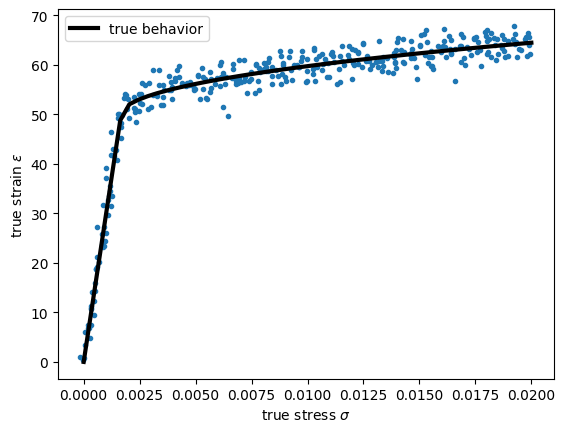

In [122]:
fig, ax = plt.subplots()

for i in range(n_samples):  
    steel.E0 = E0_values[i]
    steel.F_y0 = F_y0_values[i]
    steel.n = strain_hardening_exp_values[i]

    eps, temp, sig = \
        steel.stress(
            strain[i], 
            temperature,
            scale_strain=stddev_strain,
            scale_temperature=stddev_temperature,
            scale_stress=stddev_stress
        )
    ax.plot(eps, sig, '.', c='C0')
    

steel.E0 = E0
steel.F_y0 = F_y0
steel.n = strain_hardening_exp
eps, temp, sig = steel.stress(np.linspace(strain.min(), strain.max()), temperature)    
ax.plot(eps, sig, ls='-', lw=3, c='k', label='true behavior')

ax.legend()
ax.set(xlabel=r"true stress $\sigma$", ylabel=r"true strain $\varepsilon$")

### b) use the Python package MDSdata

(350,)


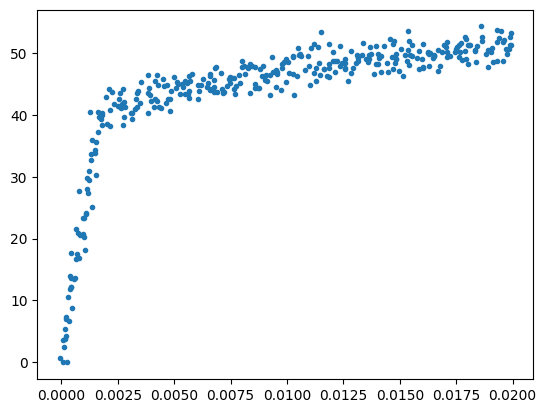

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from mdsdata import MDS1

strain, stress = MDS1.load_data(temperature=400, return_X_y=True)
print(strain.shape)
plt.scatter(strain, stress, marker='.')

In [124]:
data = MDS1.load_data(temperature=0, as_frame=True)
data.frame

,strain,stress
0,-0.000131,-0.034340
1,0.000168,1.309808
2,0.000001,2.044280
3,0.000442,2.180417
4,0.000133,3.982092
...,...,...
345,0.019678,62.485313
346,0.019664,65.485887
347,0.019933,66.986283
348,0.019689,64.734403


## 4.3 Dataset MDS-2: Microstructure Evolution with the Ising Model
The Curie temperature is the temperature above which magnetism is lost in a ferromagnetic material. For a non-dimensional scaled model (Boltzmann constant) $k_B=1$ and coupling force $J=1$) it is

$$T_c = \frac{2}{\ln(1+\sqrt{2})} \approx 2.269$$

In the following we pick microstructures that are below, at, and above the Curie temperature:

In [125]:
import matplotlib.pyplot as plt
from mdsdata import load_Ising

images, labels, temperatures = load_Ising()

In [126]:
Tc = 2 / (np.log(1 + 2 ** 0.5))

# find the element number that is closest to the Curie temperature
idx_at_Tc = np.argmin(np.abs(temperatures - Tc))
print("at Tc:  idx_below =", idx_at_Tc, "  with   T =", temperatures[idx_at_Tc])

# find the element number that is closest to 60% of the Curie temperature
idx_below_TC = np.argmin(np.abs(temperatures - 0.6 * Tc))
print("0.6 Tc:  idx_below =", idx_below_TC, "  with   T =", temperatures[idx_below_TC])

# find the element number that is closest to 130% of the Curie temperature
idx_above_TC = np.argmin(np.abs(temperatures - 1.3 * Tc))
print("1.3 Tc:  idx_below =", idx_above_TC, "  with   T =", temperatures[idx_above_TC])

at Tc:  idx_below = 2507   with   T = 2.2704978255075803
0.6 Tc:  idx_below = 1454   with   T = 1.3620898989490084
1.3 Tc:  idx_below = 3252   with   T = 2.950297902973899


[Text(0.5, 1.0, 'T=2.95, label=1')]

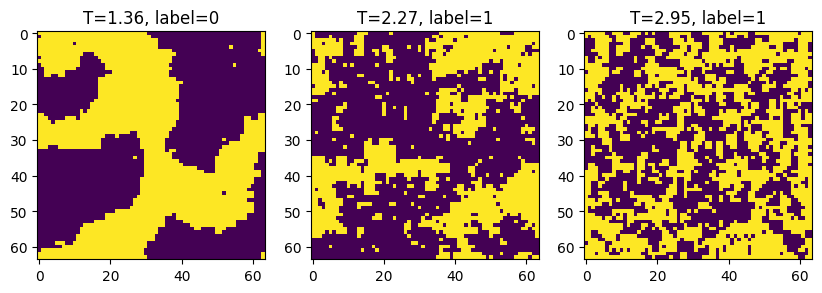

In [127]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(10, 4))
ax0.imshow(images[idx_below_TC])
ax0.set(title=f"T={temperatures[idx_below_TC]:.2f}, label={labels[idx_below_TC]}")
ax1.imshow(images[idx_at_Tc])
ax1.set(title=f"T={temperatures[idx_at_Tc]:.2f}, label={labels[idx_at_Tc]}")
ax2.imshow(images[idx_above_TC])
ax2.set(title=f"T={temperatures[idx_above_TC]:.2f}, label={labels[idx_above_TC]}")

The temperature of the microstructure examples are roughly uniform distributed:

(array([482., 518., 454., 535., 518., 488., 473., 515., 489., 528.]),
 array([3.69136398e-04, 4.53857922e-01, 9.07346707e-01, 1.36083549e+00,
        1.81432428e+00, 2.26781306e+00, 2.72130185e+00, 3.17479064e+00,
        3.62827942e+00, 4.08176821e+00, 4.53525699e+00]),
 <BarContainer object of 10 artists>)

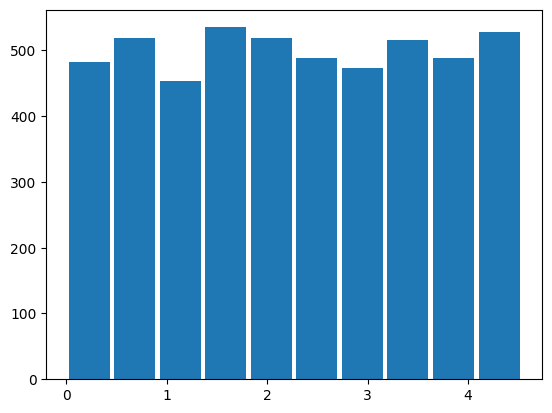

In [128]:
plt.hist(temperatures, rwidth=0.9)

... and these are some of the "Ising-DS light" images:

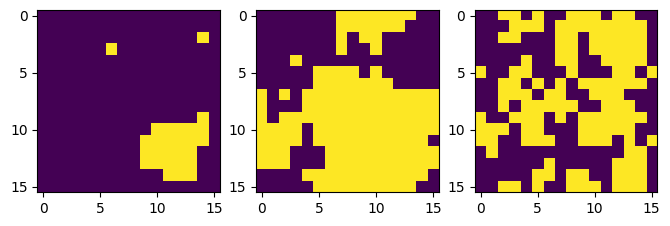

In [129]:
from mdsdata import load_Ising_light
images, labels, temperatures = load_Ising_light()

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2.5))
ax0.imshow(images[3800])
ax1.imshow(images[2800])
ax2.imshow(images[1000])

## 4.4 Dataset MDS-3:   Cahn-Hilliard Model


The dataset contains 989 images.
They are 64 x 64 pixel in size.
The minimum energy is:  457.7
The maximum energy is:  1095.3


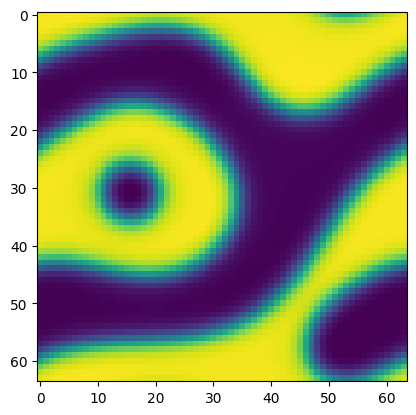

In [130]:
import matplotlib.pyplot as plt
from mdsdata import load_CahnHilliard

images, energies = load_CahnHilliard(simulation_number=0)
plt.imshow(images[10])

print("The dataset contains", images.shape[0], "images.")
print("They are", images.shape[1], "x", images.shape[2], "pixel in size.")
print(f"The minimum energy is: {energies.min(): .1f}")
print(f"The maximum energy is: {energies.max(): .1f}")

## 4.5 Dataset MDS-4:   Properties of Chemical Elements


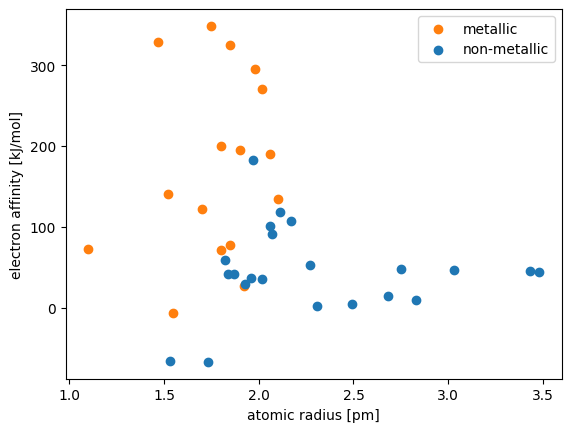

In [131]:
import matplotlib.pyplot as plt
from mdsdata import load_elements

atomic_radius, electron_affinity, \
    ionization_energy, electronegativity, label = load_elements()

fig, ax = plt.subplots()
ax.scatter(atomic_radius[label==0], electron_affinity[label==0], c='C1', label='metallic')
ax.scatter(atomic_radius[label==1], electron_affinity[label==1], c='C0', label='non-metallic')
ax.set(xlabel='atomic radius [pm]', ylabel='electron affinity [kJ/mol]')
ax.legend()


To see all feature names you can use print(features_names). If you prefer to use the Python package pandas then the following code creates a DataFrame and additionally adds the text-label for each value of the target variable:

In [132]:
from mdsdata import MDS4

# load the data and obtain the DataFrame object
chem_elem = MDS4.load_data(as_frame=True)
df = chem_elem.frame

# include the text string labels for the 2 different classes of data:
df['label'] = df['target'].map(lambda i: chem_elem.target_names[i])
display(df[18:25])

,atomic_radius,electron_affinity,ionization energy,electronegativity,target,label
18,2.02,35.12,715.60,1.80,1,non-metallic
19,2.06,100.92,830.58,2.05,1,non-metallic
20,2.07,90.92,702.94,1.90,1,non-metallic
21,1.97,183.30,811.83,2.00,1,non-metallic
22,1.10,72.77,1312.05,2.20,0,metallic
23,1.92,26.99,800.64,2.04,0,metallic
24,1.70,121.78,1086.45,2.55,0,metallic


## 4.6 Dataset MDS-5:   Nanoindentation of a Cu-Cr Composite

The feature matrix has 2 features in columns: ["Young's modulus", 'hardness']
 ... and 938 data records as rows of X.
The class labels 0...3 of Y correspond to: ['0% Cr', '25% Cr', '60% Cr', '100% Cr']


[Text(0.5, 0, "Young's modulus [GPa]"), Text(0, 0.5, 'hardness [GPa]')]

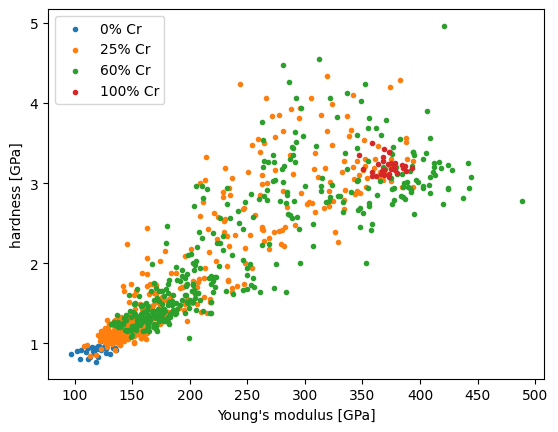

In [133]:
import matplotlib.pyplot as plt
from mdsdata import MDS5

CuCr = MDS5.load_data()
X = CuCr.feature_matrix
y = CuCr.target 
print("The feature matrix has", X.shape[1], "features in columns:", CuCr.feature_names)
print(" ... and", X.shape[0], "data records as rows of X.")
print("The class labels 0...3 of Y correspond to:", CuCr.target_names)

modulus = X[:, 0]
hardness = X[:, 1]
material = y

fig, ax = plt.subplots()
ax.scatter(modulus[y==0], hardness[y==0], marker='.', c='C0', label=CuCr.target_names[0])
ax.scatter(modulus[y==1], hardness[y==1], marker='.', c='C1', label=CuCr.target_names[1])
ax.scatter(modulus[y==2], hardness[y==2], marker='.', c='C2', label=CuCr.target_names[2])
ax.scatter(modulus[y==3], hardness[y==3], marker='.', c='C3', label=CuCr.target_names[3])

ax.legend()
ax.set(xlabel="Young's modulus [GPa]", ylabel="hardness [GPa]")

## 4.7 Dataset DS-1:   Iris Flower Dataset

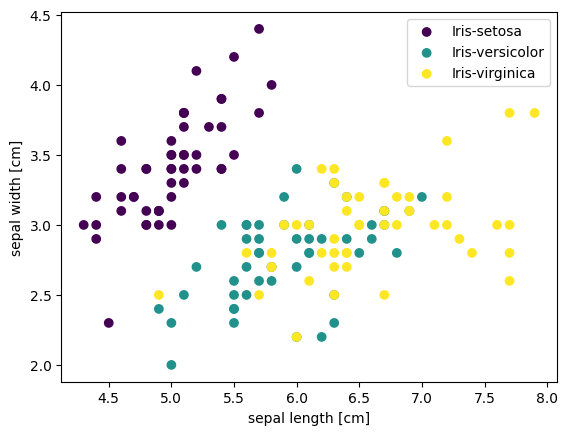

In [134]:
import matplotlib.pyplot as plt
from mdsdata import DS1

iris = DS1.load_data()
X = iris.data 
y = iris.target
class_names = iris.target_names

fig, ax = plt.subplots()
idx = y == 0
ax.scatter(X[idx,0], X[idx,1], c=y[idx], label=class_names[0], vmin=0, vmax=2)
idx = y == 1
ax.scatter(X[idx,0], X[idx,1], c=y[idx], label=class_names[1], vmin=0, vmax=2)
idx = y == 2
ax.scatter(X[idx,0], X[idx,1], c=y[idx], label=class_names[2], vmin=0, vmax=2)
ax.set(xlabel='sepal length [cm]', ylabel='sepal width [cm]')
ax.legend()

## 4.8 Dataset DS-2:   The MNIST Handwritten Digits Dataset

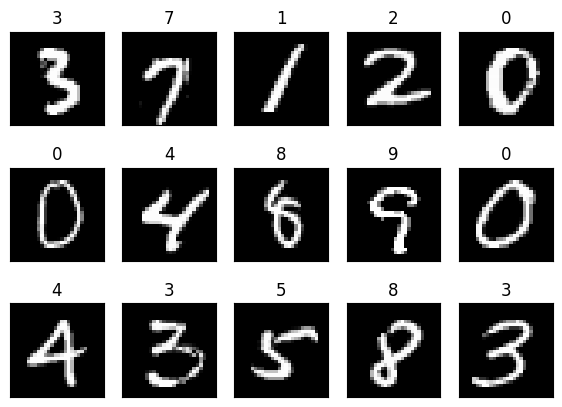

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from mdsdata import load_MNIST_digits

rng = np.random.default_rng()  # create a random number generator

# If you want to use the testing dataset instead use "train=False":
images, labels = load_MNIST_digits(train=True)

fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(7, 5))
for ax in axes.ravel():
    idx = rng.integers(low=0, high=images.shape[0])
    ax.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
    ax.set(xticks=[], yticks=[], title=f"{labels[idx]}")

... and the "light" version, i.e., the "Alpaydin" handwritten digits dataset:

[[ 0  1  6 ...  1  0  0]
 [ 0  0 10 ...  3  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  1 ...  6  0  0]
 [ 0  0  2 ... 12  0  0]
 [ 0  0 10 ... 12  1  0]]
[0 0 7 ... 8 9 8]
[[ 0  1  6 ...  1  0  0]
 [ 0  0 10 ...  3  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  1 ...  6  0  0]
 [ 0  0  2 ... 12  0  0]
 [ 0  0 10 ... 12  1  0]]
[0 0 7 ... 8 9 8]


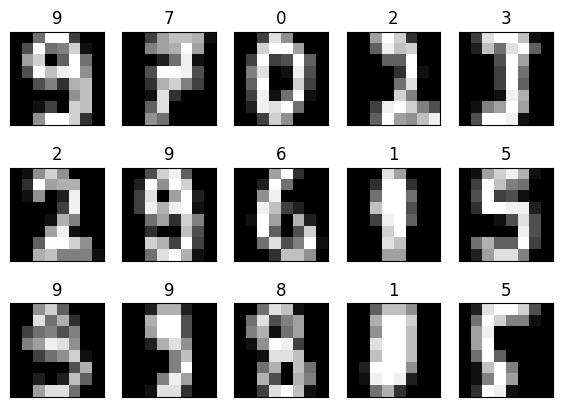

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Variant 1: Loading the data
from mdsdata import DS2_light
images, labels = DS2_light().load_data(return_X_y=True)

# Variant 2: Loading the data
from mdsdata import load_Alpaydin_digits
images, labels = load_Alpaydin_digits()

rng = np.random.default_rng()  # create a random number generator

fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(7, 5))
for ax in axes.ravel():
    idx = rng.integers(low=0, high=images.shape[0])
    ax.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
    ax.set(xticks=[], yticks=[], title=f"{labels[idx]}")